## PySpark Conversion of Bitcoin Analysis Notebook

In [1]:

# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *


In [2]:

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Bitcoin Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "12g") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/05 21:47:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/05 21:47:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:


import pyspark.sql.functions as F

# Load data using PySpark
# parquet_file = 'data/bitcoin (1).pq'
# df = spark.read.parquet(parquet_file)
df = spark.read.csv("../data/bitcoin.csv", inferSchema=True, header=True) # For local
df = df.drop('_c0')
majority_class = df.filter(F.col("label") == "white")
minority_class = df.filter(F.col("label") != "white")
# change minority class label to "black"
minority_class = minority_class.withColumn("label", F.lit("black"))
# minority class has around 42k rows
majority_class_downsampled = majority_class.sample(fraction=0.015, seed=1024)
df = majority_class_downsampled.union(minority_class)

df.show(5)  # Display the first few rows of the dataset


+--------------------+----+---+------+-------------------+-----+------+---------+-------+-----+
|             address|year|day|length|             weight|count|looped|neighbors| income|label|
+--------------------+----+---+------+-------------------+-----+------+---------+-------+-----+
|147dRpRoYQxpf5WGn...|2011|  1|    42|  0.130874633789062|    2|     2|        5|  4.1E8|white|
|1JVpLsXkcBZZpczmg...|2011|  1|    26|    0.5001220703125|    2|     0|        2|4.731E9|white|
|1P4amfLUsoGT6x1yd...|2011|  1|    32|   1.52587890625E-5|    1|     0|        1|  3.2E7|white|
|191bVV6GuR5hzn7qy...|2011|  1|    66|5.96046447753906E-8|    1|     0|        2| 2.32E8|white|
|16njLGdhqwiJXdJPM...|2011|  2|     4|              0.375|    2|     0|        2|  8.7E7|white|
+--------------------+----+---+------+-------------------+-----+------+---------+-------+-----+
only showing top 5 rows



In [4]:
# df.toPandas().to_csv("data/bitcoin.csv")

Adding column to identify suspicious transactions

In [5]:
from pyspark.sql.functions import when, col

df = df.withColumn('fraud', when(col('label') == 'white', False).otherwise(True))

# Dropping unwanted columns for EDA
df = df.drop('address', 'label')


In [6]:
# Distribution of labels
df.groupBy('fraud').count().show()

+-----+-----+
|fraud|count|
+-----+-----+
|false|43302|
| true|41413|
+-----+-----+



Histograms for all transactions

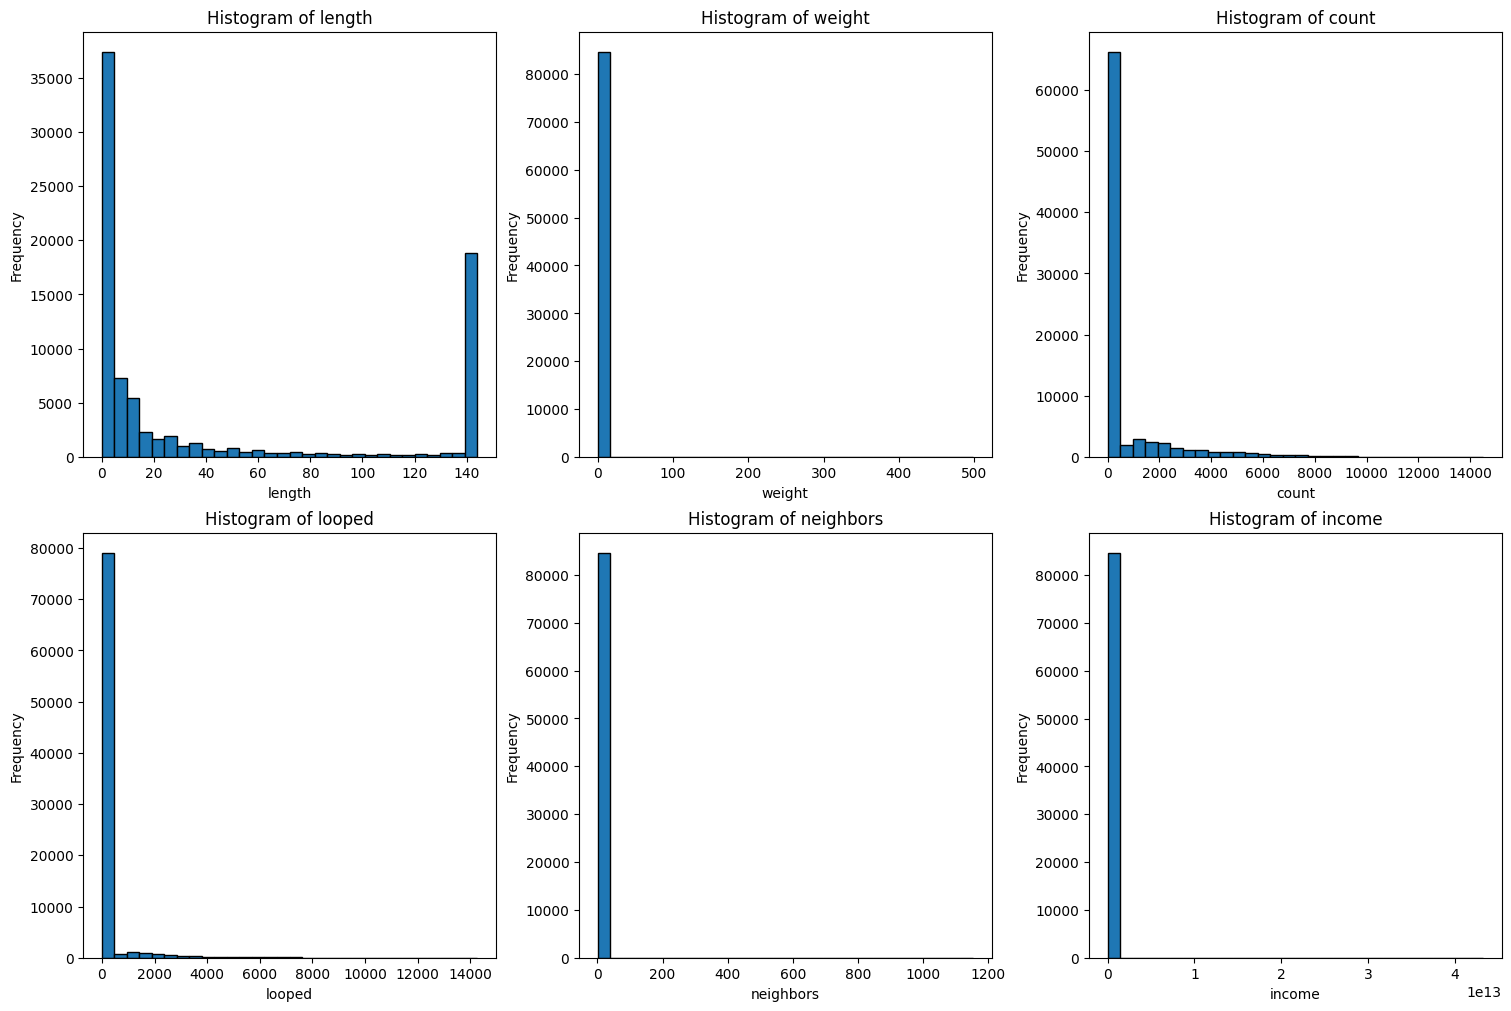

In [7]:
import matplotlib.pyplot as plt

# Select the column for which you want to create a histogram
columns = ["length", "weight", "count", "looped", "neighbors", "income"]

figsize = (15,10)
bins=30

fig, axes = plt.subplots(nrows=(len(columns) + 2) // 3, ncols=3, figsize=figsize, constrained_layout=True)
axes = axes.flatten()

for i, column in enumerate(columns):
    # Collect column data as a list
    data = df.select(column).rdd.flatMap(lambda x: x).collect()
    
    # Plot histogram for the current column
    axes[i].hist(data, bins=bins, edgecolor='black')
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

Histograms for suspicious transactions

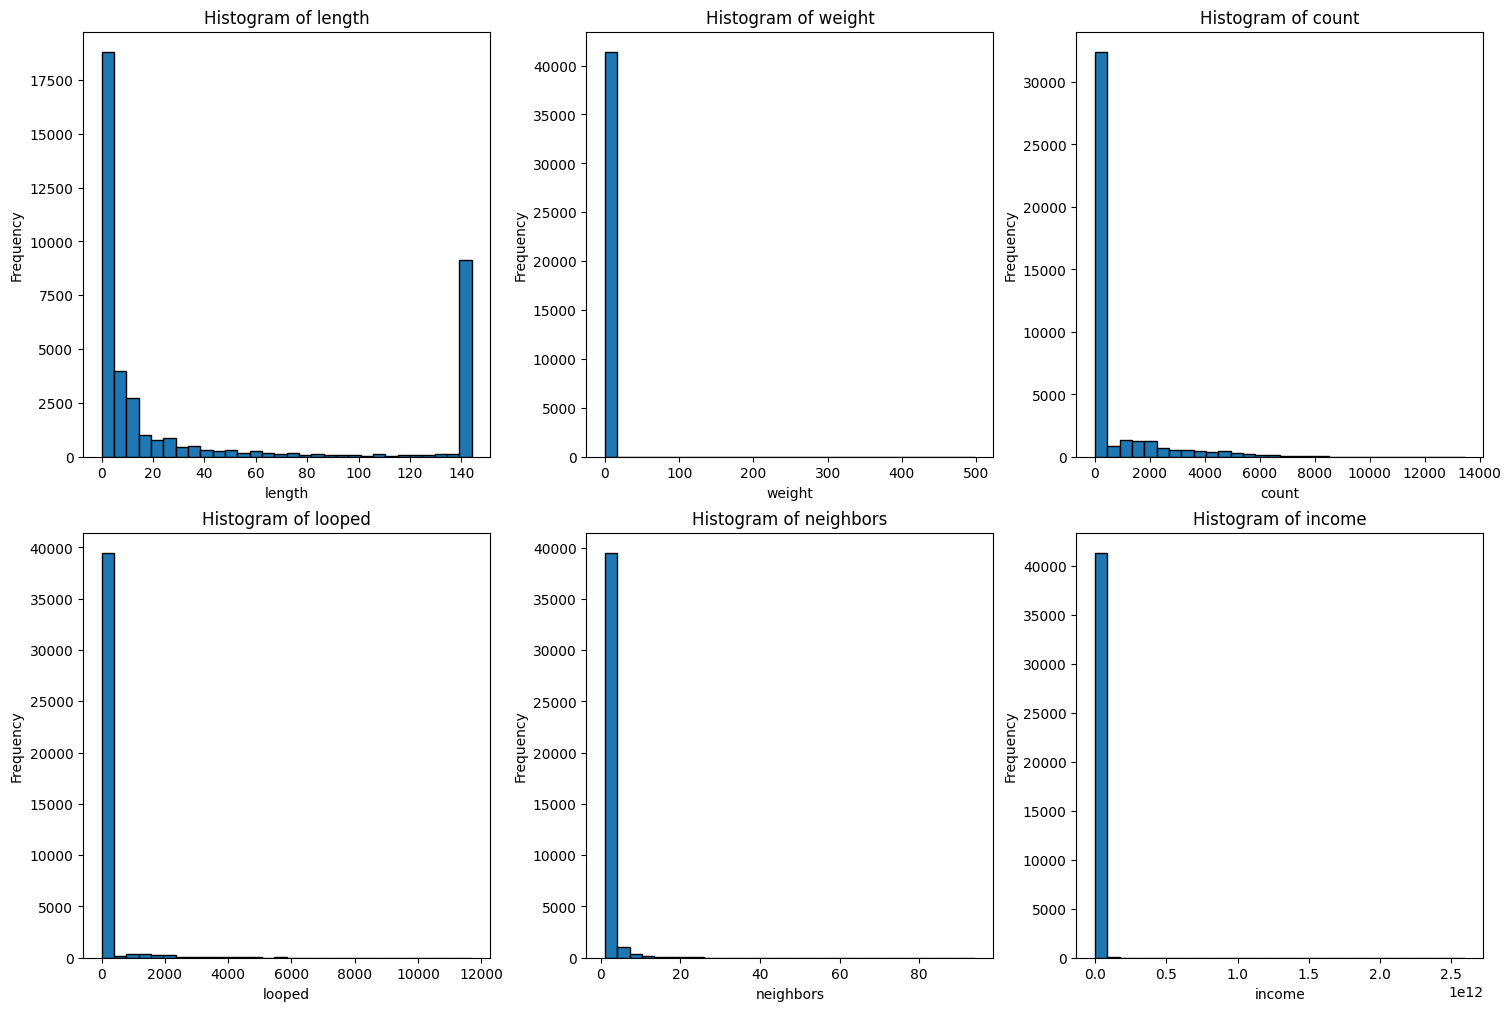

In [8]:
import matplotlib.pyplot as plt

# Select the column for which you want to create a histogram
columns = ["length", "weight", "count", "looped", "neighbors", "income"]

figsize = (15,10)
bins=30

fig, axes = plt.subplots(nrows=(len(columns) + 2) // 3, ncols=3, figsize=figsize, constrained_layout=True)
axes = axes.flatten()

for i, column in enumerate(columns):
    # Collect column data as a list
    data = df.filter(df['fraud'] == True).select(column).rdd.flatMap(lambda x: x).collect()
    
    # Plot histogram for the current column
    axes[i].hist(data, bins=bins, edgecolor='black')
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

Boxplots for all transactions

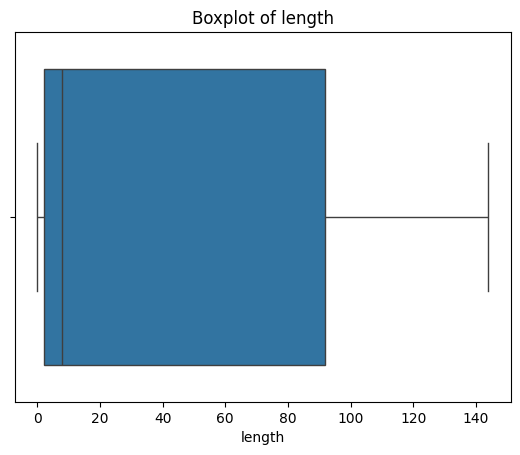

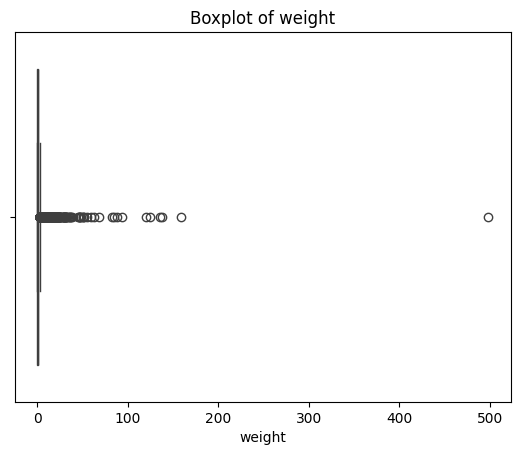

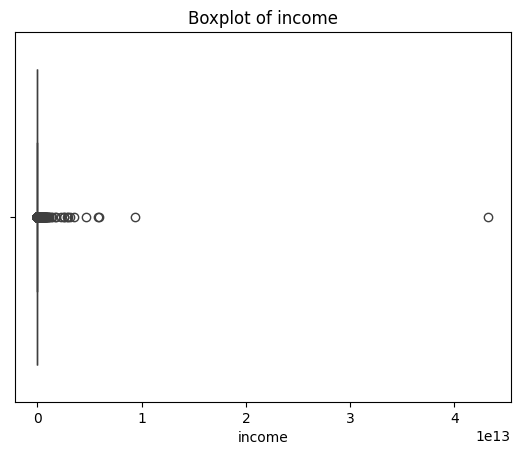

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the columns to plot
columns = ['length', 'weight', 'income']

pandas_df = df.select(columns).toPandas()

# Iterate through each column and plot a boxplot
for col in columns:
    sns.boxplot(data=pandas_df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

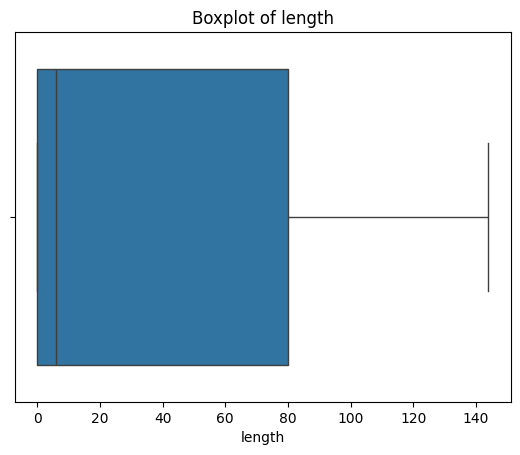

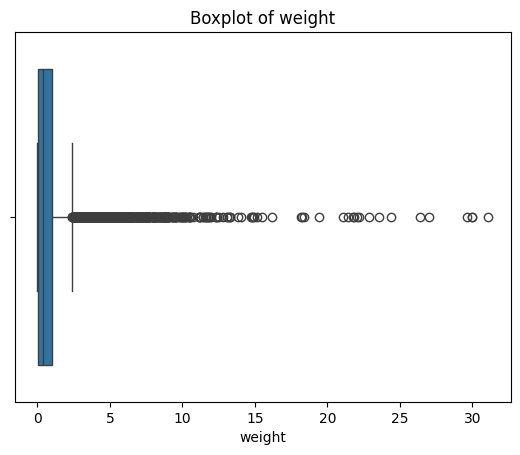

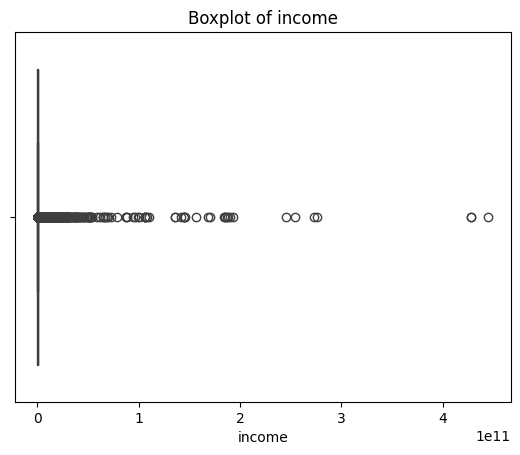

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the columns to plot
columns = ['length', 'weight', 'income']

pandas_df = df.filter(df['fraud'] == True).filter(df['weight'] < 100).select(columns).toPandas() # removing some outliers 

# Iterate through each column and plot a boxplot
for col in columns:
    sns.boxplot(data=pandas_df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

24/12/05 21:48:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


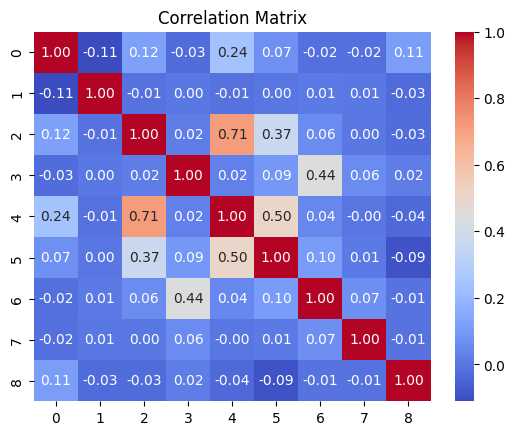

In [11]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df_vector = assembler.transform(df)

# Compute correlation matrix
matrix = Correlation.corr(df_vector, 'features').head()[0]
correlation = matrix.toArray()

# Visualize correlation matrix
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

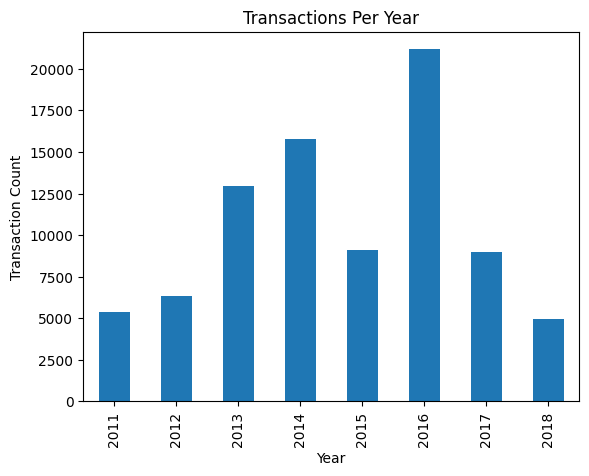

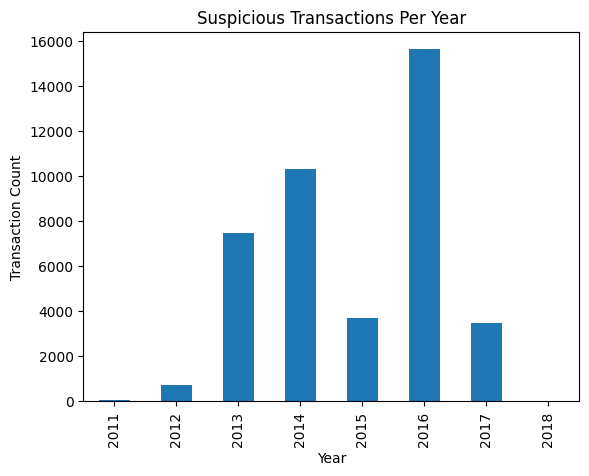

In [12]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# All Transactions by year
df.groupBy('year').count().orderBy('year').toPandas().plot(kind='bar', x='year', y='count', legend=False)
plt.title('Transactions Per Year')
plt.xlabel('Year')
plt.ylabel('Transaction Count')
plt.show()

# Suspicious transactions by year
df.filter(df['fraud'] == True).groupBy('year').count().orderBy('year').toPandas().plot(kind='bar', x='year', y='count', legend=False)
plt.title('Suspicious Transactions Per Year')
plt.xlabel('Year')
plt.ylabel('Transaction Count')
plt.show()

In [13]:
# Mean income and count by fraud
grouped = df.groupby('fraud').agg({'income': 'mean', 'count': 'mean'})
grouped.show()

+-----+-------------------+-----------------+
|fraud|        avg(income)|       avg(count)|
+-----+-------------------+-----------------+
|false|5.268470267966122E9|714.8917371022123|
| true|7.833720943926061E8|  599.81027696617|
+-----+-------------------+-----------------+



+----+---+------+--------------------+-----+------+---------+------------------+-----+------------------+
|year|day|length|              weight|count|looped|neighbors|            income|fraud|          z_income|
+----+---+------+--------------------+-----+------+---------+------------------+-----+------------------+
|2011| 39|     0|                 0.5|    1|     0|        1|          7.554E11|false| 4.728281287630399|
|2011| 61|    46| 5.96046447753906E-8|    1|     0|        2|         3.5143E12|false|22.067690856920294|
|2011| 61|    34|   3.814697265625E-6|    1|     0|        2|         5.9346E12|false| 37.27903341393662|
|2011| 71|     2|                2.25|    3|     1|        4|           1.75E12|false|10.979242452448162|
|2011| 73|     2|                 6.5|    7|     1|        8|            1.0E12|false| 6.265567735362577|
|2011|109|   120|  0.0115890561298875|   94|     0|        2|       9.400397E12|false| 59.06121967187137|
|2011|111|     0|                 1.0|    1|  

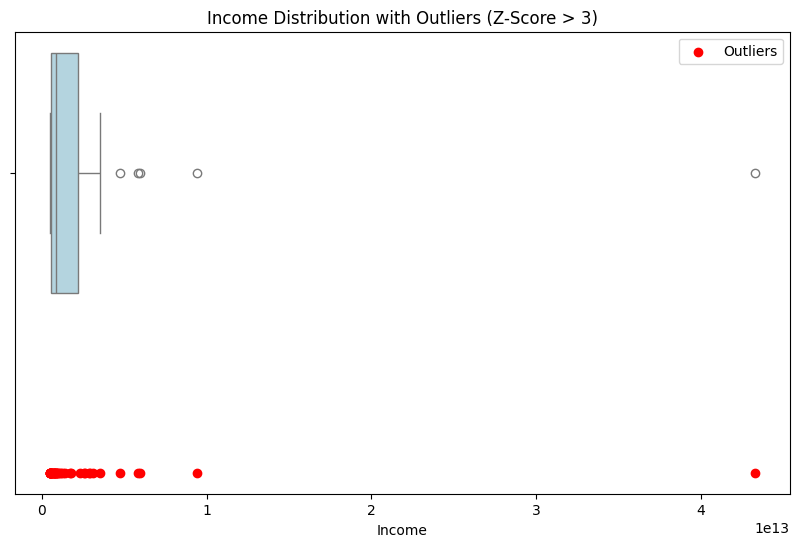

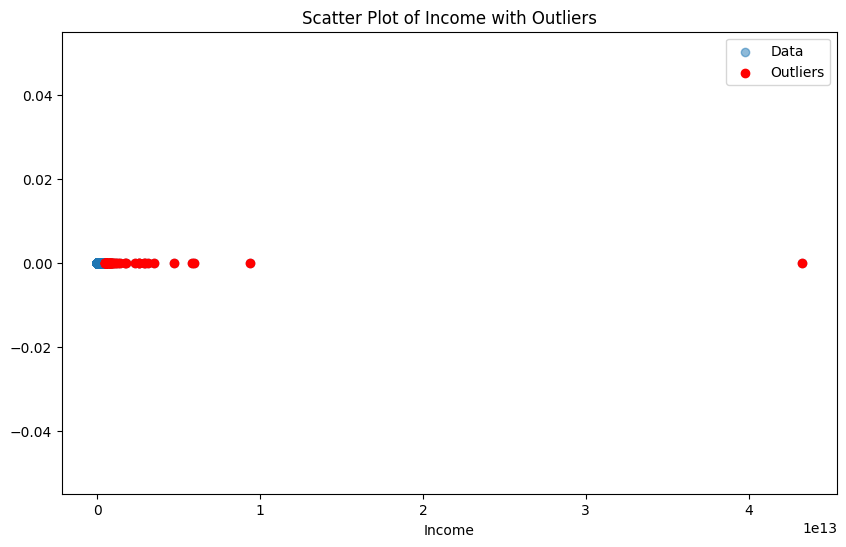

In [14]:
# Calculate mean and standard deviation for income
mean_income = df.select(F.mean('income')).collect()[0][0]
stddev_income = df.select(F.stddev('income')).collect()[0][0]

# Create a new column for Z-score calculation
df = df.withColumn('z_income', (df['income'] - mean_income) / stddev_income)

# Identify outliers where the absolute Z-score is greater than 3
outliers = df.filter(F.abs(df['z_income']) > 3)

# Show the outliers
outliers.show()

df_outliers_pandas = outliers.toPandas()
df_pandas = df.toPandas()

plt.figure(figsize=(10, 6))

# Box plot to show income distribution and outliers
sns.boxplot(x=df_outliers_pandas['income'], color='lightblue')

# Highlight outliers in red
plt.scatter(df_outliers_pandas['income'], np.ones(len(df_outliers_pandas)), color='red', label='Outliers')

plt.title('Income Distribution with Outliers (Z-Score > 3)')
plt.xlabel('Income')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df_pandas['income'], np.zeros_like(df_pandas['income']), alpha=0.5, label='Data')
plt.scatter(df_outliers_pandas['income'], np.zeros_like(df_outliers_pandas['income']), color='red', label='Outliers')
plt.title('Scatter Plot of Income with Outliers')
plt.xlabel('Income')
plt.legend()
plt.show()

+-----+-------------------+-------------+--------------------+------------------+-----------------+------------------+-----------------+-------------+-----------------+
|fraud|        mean_income|median_income|          std_income|       mean_weight|    median_weight|        std_weight|      mean_length|median_length|       std_length|
+-----+-------------------+-------------+--------------------+------------------+-----------------+------------------+-----------------+-------------+-----------------+
|false|5.268470267966122E9|        2.0E8|2.220935018108655...|0.5335718134437114|             0.25|2.1896330220100872|44.76075008082768|            8|58.78527561908842|
| true|7.833720943926061E8|       1.25E8|1.423362166675374...|0.6274532237068302|0.387770451060351|2.6676247844294183| 41.6369256030715|            6|58.44235003930521|
+-----+-------------------+-------------+--------------------+------------------+-----------------+------------------+-----------------+-------------+-----

<Figure size 1200x800 with 0 Axes>

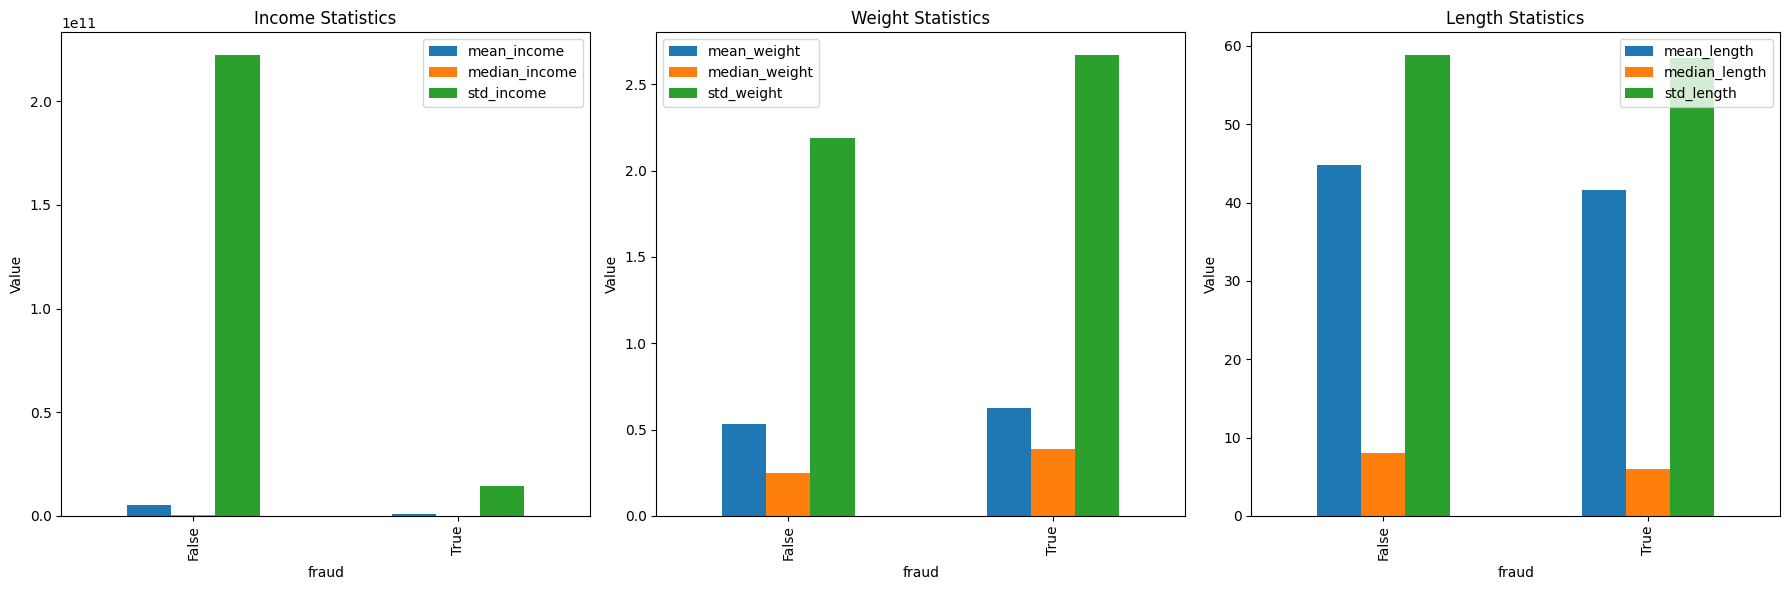

In [15]:
from pyspark.sql import functions as F

# Group by fraud status and calculate statistics for income, weight, and length
fraud_stats = df.groupBy('fraud').agg(
    F.mean('income').alias('mean_income'),
    F.expr('percentile_approx(income, 0.5)').alias('median_income'),
    F.stddev('income').alias('std_income'),
    F.mean('weight').alias('mean_weight'),
    F.expr('percentile_approx(weight, 0.5)').alias('median_weight'),
    F.stddev('weight').alias('std_weight'),
    F.mean('length').alias('mean_length'),
    F.expr('percentile_approx(length, 0.5)').alias('median_length'),
    F.stddev('length').alias('std_length')
)

# Show the result
fraud_stats.show()

# Convert fraud_stats to Pandas DataFrame for plotting
fraud_stats_pandas = fraud_stats.toPandas()

# Set the figure size
plt.figure(figsize=(12, 8))

# Plotting the statistics for each fraud status
fraud_stats_pandas.set_index('fraud', inplace=True)

# Plot mean, median, and std for income, weight, and length
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for 'income'
fraud_stats_pandas[['mean_income', 'median_income', 'std_income']].plot(kind='bar', ax=axes[0], title='Income Statistics')
axes[0].set_ylabel('Value')

# Plot for 'weight'
fraud_stats_pandas[['mean_weight', 'median_weight', 'std_weight']].plot(kind='bar', ax=axes[1], title='Weight Statistics')
axes[1].set_ylabel('Value')

# Plot for 'length'
fraud_stats_pandas[['mean_length', 'median_length', 'std_length']].plot(kind='bar', ax=axes[2], title='Length Statistics')
axes[2].set_ylabel('Value')

plt.tight_layout()
plt.show()